# Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import datetime

In [2]:
# Load transformed files

file_names = ['X_train_unscaled', 'X_test_unscaled', 'X_train_scaled', 'X_test_scaled', \
              'y_train', 'y_test' ,'X_val_unscaled' , 'X_val_scaled', 'y_val']

# Base directory path
directory = r'C:\Users\Travi\OneDrive\Documents\GitHub\Springboard-Data-Science-Capstone-Project-2\nhl data\shots_07_22'

dataframes = {}

# Loop through each dataset name
for file in file_names:
    # Construct the full path dynamically
    file_path = f"{directory}\\{file}.csv"
    file_name = os.path.basename(file)
    
    # Read the CSV into a DataFrame and store it in the dictionary
    dataframes[file] = pd.read_csv(file_path)
    print(f"{file_name} loaded successfully")
    
# Extract DataFrames from the dictionary and assign them to individual variables
for dataset_name, df in dataframes.items():
            globals()[dataset_name] = df  # Create a variable with the name of the dataset

X_train_unscaled loaded successfully
X_test_unscaled loaded successfully
X_train_scaled loaded successfully
X_test_scaled loaded successfully
y_train loaded successfully
y_test loaded successfully
X_val_unscaled loaded successfully
X_val_scaled loaded successfully
y_val loaded successfully


### Class Distribution

In [3]:
# Class distribution
goal_counts = y_train.value_counts()
print("Class Distribution in Training Set:")
print(goal_counts)

# Calculate imbalance ratio
imbalance_ratio = goal_counts[0] / goal_counts[1]  # Non-goals / Goals
print(f"Imbalance Ratio (Non-goals:Goals) = {imbalance_ratio:.2f}")

Class Distribution in Training Set:
goal
0       1102397
1        111871
Name: count, dtype: int64
Imbalance Ratio (Non-goals:Goals) = 9.85


### Resample and Undersampling to Balance Class Distribution

#### SMOTE 

In [4]:
X_scaled_resampled, y_scaled_resampled = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train_scaled, y_train)

In [5]:
X_unscaled_resampled, y_resampled = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train_unscaled, y_train)

#### Unersampling

In [8]:
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Apply undersampling to training data
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_scaled, y_train)

In [9]:
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Apply undersampling to training data
X_train_resampled_unscaled, y_train_resampled_unscaled = undersample.fit_resample(X_train_unscaled, y_train)

### Logistic Regression Model

First I trained all the models on the original data as a baseline. I then training the models using the resampled data (both oversampling and undersampling) to help with the class imbalance.  

To evaluate my model, I will be focused on maximizing recall. I want to catch all legitimate goal-scoring chances, even at the risk of some false alarms.

The goal is to use the model to uncover hidden offensive potential — e.g., finding players who create high-quality chances that others don’t finish often.

In [10]:
# Train the model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train.values.ravel())

# Predict and evaluate
y_pred_log = log_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log))

# ROC-AUC Score
y_pred_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_log = roc_auc_score(y_test, y_pred_proba_log)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.96      0.77      0.86     11231
           1       0.25      0.72      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.75      0.61     12391
weighted avg       0.90      0.77      0.81     12391

ROC-AUC: 0.828552589968038


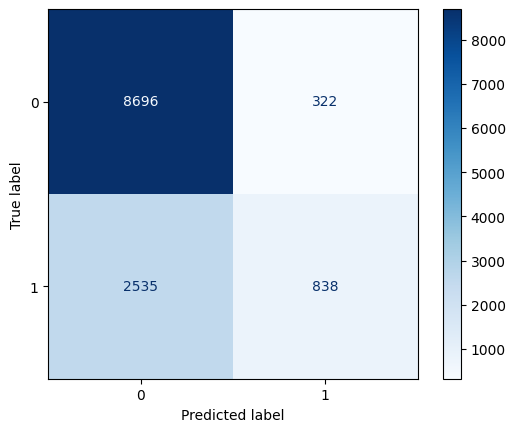

In [11]:
cm_log_model = confusion_matrix(y_pred_log, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model)
disp.plot(cmap=plt.cm.Blues)

In [12]:
# Train the model
log_model2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model2.fit(X_train_resampled, y_train_resampled.values.ravel())

# Predict and evaluate
y_pred_log2 = log_model2.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log2))

# ROC-AUC Score
y_pred_proba_log2 = log_model2.predict_proba(X_test_scaled)[:, 1]
roc_auc_log2 = roc_auc_score(y_test, y_pred_proba_log2)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.96      0.77      0.86     11231
           1       0.25      0.72      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.75      0.61     12391
weighted avg       0.90      0.77      0.81     12391

ROC-AUC: 0.828552589968038


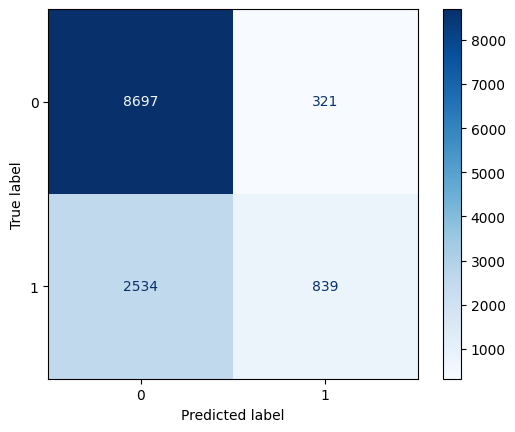

In [13]:
cm_log_model2 = confusion_matrix(y_pred_log2, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model2)
disp.plot(cmap=plt.cm.Blues)

In [14]:
# Train the model
log_model3 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model3.fit(X_scaled_resampled, y_scaled_resampled.values.ravel())

# Predict and evaluate
y_pred_log3 = log_model3.predict(X_test_scaled)

print(classification_report(y_test, y_pred_log3))

# ROC-AUC Score
y_pred_proba_log3 = log_model3.predict_proba(X_test_scaled)[:, 1]
roc_auc_log3 = roc_auc_score(y_test, y_pred_proba_log3)
print(f"ROC-AUC: {roc_auc_log}")

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     11231
           1       0.25      0.72      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.75      0.62     12391
weighted avg       0.90      0.77      0.82     12391

ROC-AUC: 0.828552589968038


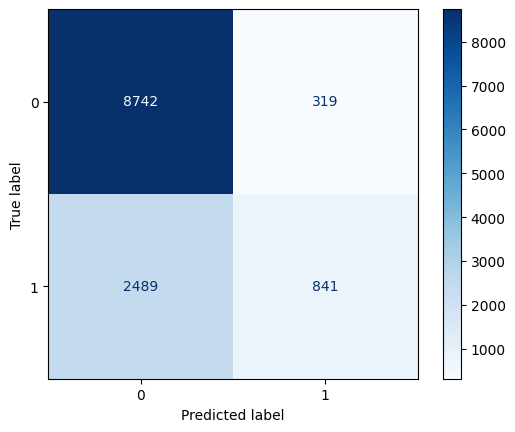

In [15]:
cm_log_model3 = confusion_matrix(y_pred_log3, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log_model3)
disp.plot(cmap=plt.cm.Blues)

### Hyperparamater Tuning for Logistic Regression Model

After getting a baseline for the logistic regression models, I used GridSearch to tune the hyperperameters to see if I could improve model perfomance. However, this was too resource heavy for my computer and I had to run it in Google Colab. 

In [ ]:
# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Lasso or Ridge
    'solver': ['liblinear', 'saga']  # Required for L1 regularization
}

# Initialize model
log_reg = LogisticRegression(max_iter=500, class_weight='balanced')

# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled_unscaled, y_train_resampled_unscaled)

# Best Parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best Model
best_log_reg = grid_search.best_estimator_

### Random Forest Model

Next, I explored Random Forest Model due to its ablity to handle non-linear relationships and outliers better than logistic regression. I repeated the same process with Random Forest as I did with Logistic Regression

In [16]:
# Train the model
forest_model = RandomForestClassifier(n_estimators = 100,class_weight='balanced',random_state=42)
forest_model.fit(X_train_unscaled, y_train.values.ravel())

# Predict
y_pred_forest = forest_model.predict(X_test_unscaled)
y_pred_proba_forest = forest_model.predict_proba(X_test_unscaled)[:, 1] 

# Evaluate
print(classification_report(y_test, y_pred_forest))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11231
           1       0.89      0.18      0.31      1160

    accuracy                           0.92     12391
   macro avg       0.91      0.59      0.63     12391
weighted avg       0.92      0.92      0.90     12391

ROC-AUC: 0.8314779520354684


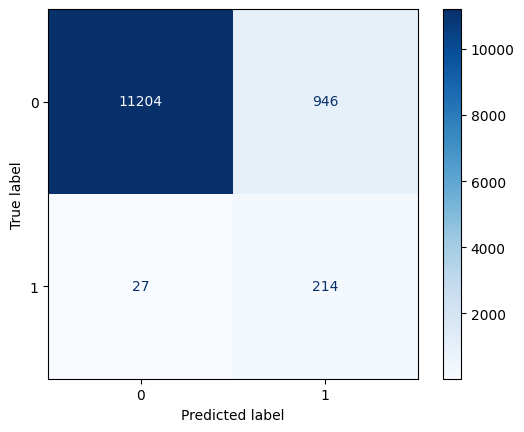

In [17]:
cm_forest_model = confusion_matrix(y_pred_forest, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model)
disp.plot(cmap=plt.cm.Blues)

In [18]:
forest_model2 = RandomForestClassifier(n_estimators = 100,random_state=42)
forest_model2.fit(X_train_resampled, y_train_resampled.values.ravel())

y_pred_forest2 = log_model2.predict(X_test_scaled)

print(classification_report(y_test, y_pred_forest2))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86     11231
           1       0.25      0.72      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.75      0.61     12391
weighted avg       0.90      0.77      0.81     12391



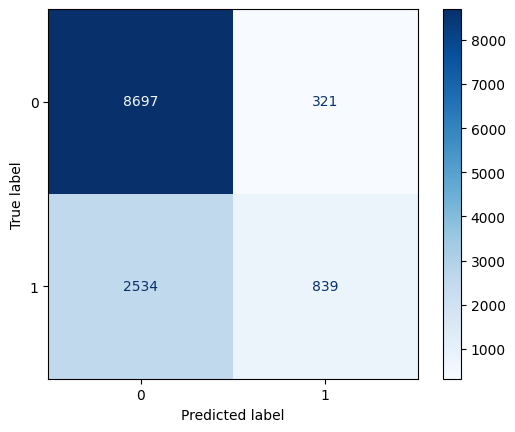

In [19]:
cm_forest_model2 = confusion_matrix(y_pred_forest2, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model2)
disp.plot(cmap=plt.cm.Blues)

In [21]:
forest_model3 = RandomForestClassifier(n_estimators = 100,random_state=42)
forest_model3.fit(X_unscaled_resampled, y_resampled.values.ravel())

y_pred_forest3 = log_model3.predict(X_test_scaled)

print(classification_report(y_test, y_pred_forest3))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     11231
           1       0.25      0.72      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.75      0.62     12391
weighted avg       0.90      0.77      0.82     12391



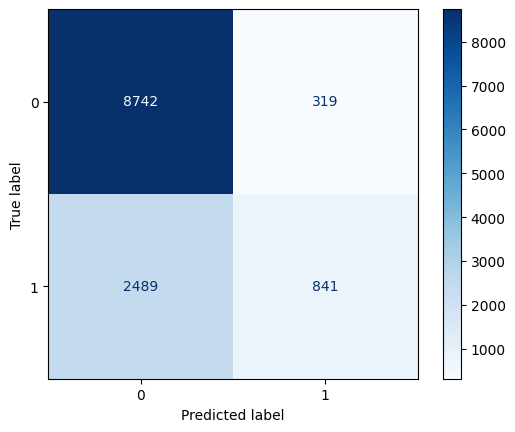

In [22]:
cm_forest_model3 = confusion_matrix(y_pred_forest3, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model3)
disp.plot(cmap=plt.cm.Blues)

### Random Forest Hyperparameter Tuning

In [77]:
# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [5, 10, 20, None],  # Tree depth
    'min_samples_split': [2, 5, 10],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None]  # Feature selection
}

# Initialize model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=20, scoring='f1', cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_resampled_unscaled, y_train_resampled_unscaled)

# Best Parameters
print("Best Hyperparameters:", random_search.best_params_)

# Best Model
best_rf_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Travi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}


In [23]:
# Train the model
forest_model4 = RandomForestClassifier(n_estimators=100, min_samples_split=10, class_weight='balanced', min_samples_leaf=4, max_features='sqrt', max_depth=20, random_state=42)
forest_model4.fit(X_train_resampled_unscaled, y_train_resampled_unscaled.values.ravel())

# Predict
y_pred_forest4 = forest_model4.predict(X_test_unscaled)
y_pred_proba_forest4 = forest_model4.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC

# Evaluate
print(classification_report(y_test, y_pred_forest4))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_forest4))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     11231
           1       0.25      0.74      0.37      1160

    accuracy                           0.77     12391
   macro avg       0.61      0.76      0.61     12391
weighted avg       0.90      0.77      0.81     12391

ROC-AUC: 0.8391275380028799


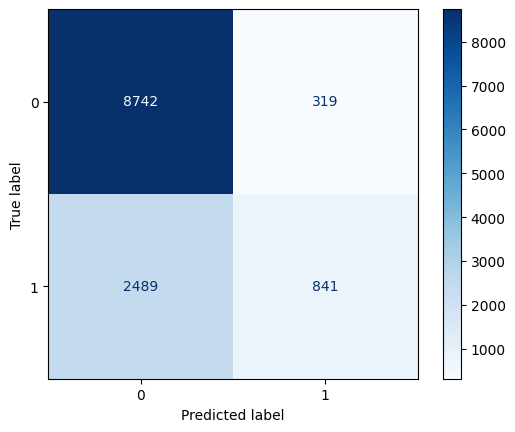

In [24]:
cm_forest_model4 = confusion_matrix(y_pred_forest3, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest_model4)
disp.plot(cmap=plt.cm.Blues)

### XGBoost Model

The last model that I tested was XGBoost. I choose this model because of its predictive performance, especially on large and complex datasets, and its ability to handle imbalanced data better than Random Forest. 

In [27]:
from xgboost import XGBClassifier

# # Train the model
xgb_model = XGBClassifier (eval_metric='logloss', scale_pos_weight=5)
xgb_model.fit(X_train_resampled_unscaled, y_train_resampled_unscaled)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb))

y_pred_proba_xgb = xgb_model.predict_proba(X_test_unscaled)[:, 1]  # For ROC-AUC

              precision    recall  f1-score   support

           0       0.98      0.51      0.67     11231
           1       0.16      0.92      0.27      1160

    accuracy                           0.55     12391
   macro avg       0.57      0.71      0.47     12391
weighted avg       0.91      0.55      0.63     12391



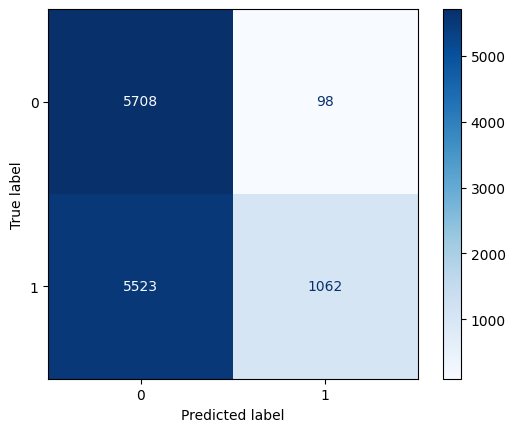

In [28]:
cm_xgb = confusion_matrix(y_pred_xgb, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap=plt.cm.Blues)

In [112]:
xgb_model2 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5)
xgb_model2.fit(X_train_unscaled, y_train)

# Evaluate
y_pred_xgb2 = xgb_model2.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb2))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     11231
           1       0.34      0.58      0.43      1160

    accuracy                           0.86     12391
   macro avg       0.65      0.73      0.67     12391
weighted avg       0.90      0.86      0.87     12391



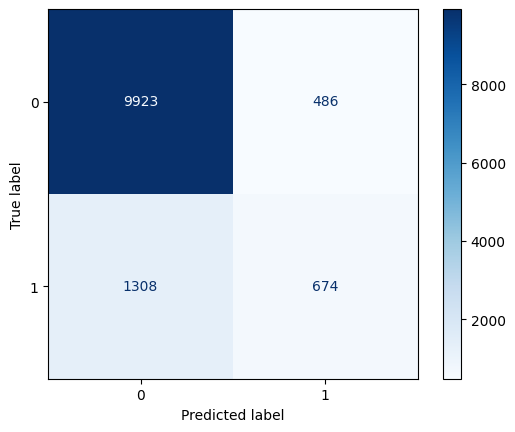

In [113]:
cm_xgb2 = confusion_matrix(y_pred_xgb2, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb2)
disp.plot(cmap=plt.cm.Blues)

In [114]:
xgb_model3 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5)
xgb_model3.fit(X_unscaled_resampled, y_resampled)

# Evaluate
y_pred_xgb3 = xgb_model3.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb3))

              precision    recall  f1-score   support

           0       0.96      0.88      0.91     11231
           1       0.33      0.60      0.43      1160

    accuracy                           0.85     12391
   macro avg       0.64      0.74      0.67     12391
weighted avg       0.90      0.85      0.87     12391



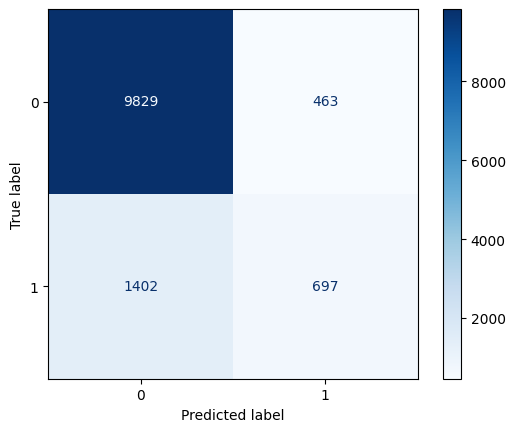

In [115]:
cm_xgb3 = confusion_matrix(y_pred_xgb3, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb3)
disp.plot(cmap=plt.cm.Blues)

### XGBoost Hyperparameter Tuning

In [37]:
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.5, 1],
    'lambda': [0, 1, 5, 10],
    'alpha' : [0, 0.1, 1, 5, 10],
    'scale_pos_weight': [1,5,7,imbalance_ratio]  # Handles class imbalance
}

# Initialize XGBoost Model
xgb2 = XGBClassifier(random_state=42, eval_metric="logloss")

# Perform RandomizedSearchCV
xgb_cv2 = RandomizedSearchCV(xgb2, param_distributions=param_grid, 
                            n_iter=20, scoring='f1', cv=5, verbose=1, random_state=42, n_jobs=-1)
xgb_cv2.fit(X_train_unscaled, y_train)

# Print Best Parameters
print("Best Hyperparameters:", xgb_cv2.best_params_)

# Evaluate Model on Test Data
best_xgb2 = xgb_cv2.best_estimator_
y_pred2 = best_xgb2.predict(X_test_unscaled)

# Display Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred2))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'scale_pos_weight': 5, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'gamma': 0, 'alpha': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     11231
           1       0.35      0.58      0.44      1160

    accuracy                           0.86     12391
   macro avg       0.65      0.73      0.68     12391
weighted avg       0.90      0.86      0.88     12391



I then tested the same models using the tuned hyperparameters

In [116]:
xgb_model4 = XGBClassifier (eval_metric='logloss', scale_pos_weight=4, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=1)
xgb_model4.fit(X_train_resampled_unscaled, y_train_resampled_unscaled)

# Evaluate
y_pred_xgb4 = xgb_model4.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb4))

              precision    recall  f1-score   support

           0       0.98      0.58      0.73     11231
           1       0.18      0.89      0.30      1160

    accuracy                           0.61     12391
   macro avg       0.58      0.73      0.51     12391
weighted avg       0.91      0.61      0.69     12391



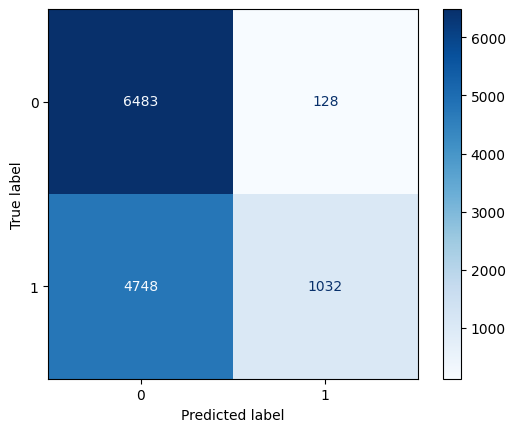

In [33]:
cm_xgb4 = confusion_matrix(y_pred_xgb4, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb4)
disp.plot(cmap=plt.cm.Blues)

In [34]:
xgb_model5 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=1)
xgb_model5.fit(X_unscaled_resampled, y_resampled)

# Evaluate
y_pred_xgb5 = xgb_model5.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb5))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     11231
           1       0.34      0.59      0.44      1160

    accuracy                           0.86     12391
   macro avg       0.65      0.74      0.68     12391
weighted avg       0.90      0.86      0.87     12391



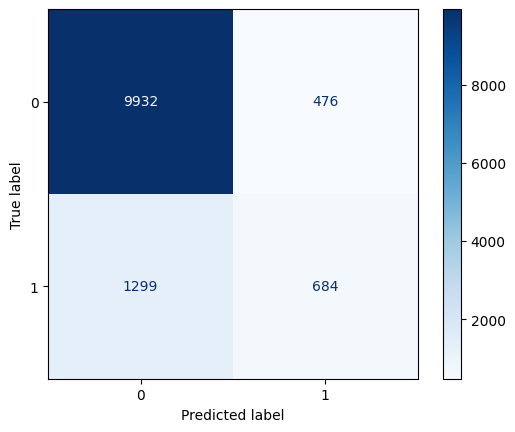

In [35]:
cm_xgb5 = confusion_matrix(y_pred_xgb5, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb5)
disp.plot(cmap=plt.cm.Blues)

In [36]:
xgb_model6 = XGBClassifier (eval_metric='logloss', scale_pos_weight=5, n_estimators=1000, min_child_weight=5, max_depth=5, learning_rate=0.1,
                            gamma=0, alpha=10)
xgb_model6.fit(X_unscaled_resampled, y_resampled)

# Evaluate
y_pred_xgb6 = xgb_model6.predict(X_test_unscaled)
print(classification_report(y_test, y_pred_xgb6))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92     11231
           1       0.34      0.58      0.43      1160

    accuracy                           0.85     12391
   macro avg       0.65      0.73      0.67     12391
weighted avg       0.90      0.85      0.87     12391



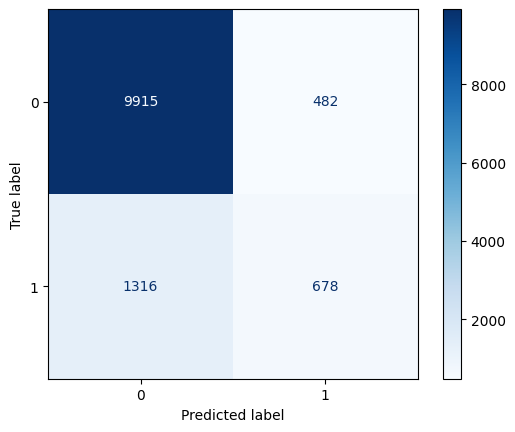

In [38]:
cm_xgb6 = confusion_matrix(y_pred_xgb6, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb6)
disp.plot(cmap=plt.cm.Blues)

# Aggretate Predictions by Player

Now that I have my trained models, I need to aggregate the goal predictions by player since out goal is to predict a players goals for the next season.  First, I started by loading the shot data from 2023 which was not included in the training data. Training data only went to 2022. 

In [117]:
test1 = pd.read_csv(r"C:\Users\Travi\OneDrive\Documents\GitHub\Springboard-Data-Science-Capstone-Project-2\nhl data\shots_2023.csv")

In [85]:
cols_to_keep = ['shotID', 'homeTeamCode', 'awayTeamCode', 'season', 'game_id','id',
            'timeSinceLastEvent', 'period', 'team', 'location', 'shotGeneratedRebound','shotAngle', 'shotAnglePlusRebound',
            'shotDistance', 'shotType', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusReboundSpeed', 
            'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent',
            'lastEventShotAngle', 'lastEventShotDistance', 'lastEventCategory', 'homeEmptyNet',
            'awayEmptyNet', 'homeSkatersOnIce', 'awaySkatersOnIce', 'playerPositionThatDidEvent', 
            'timeSinceFaceoff', 'shooterPlayerId', 'shooterLeftRight', 'xGoal', 'xFroze',
            'xRebound', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped',
            'xShotWasOnGoal', 'shotWasOnGoal', 'teamCode', 'power_play', 'situation', 'homePenalty1Length', 'awayPenalty1Length', 'goal']

test1 = test1[test1.columns.intersection(cols_to_keep)]
test1.reset_index()

,index,shotID,awayEmptyNet,awayPenalty1Length,awaySkatersOnIce,awayTeamCode,distanceFromLastEvent,game_id,goal,homeEmptyNet,...,teamCode,timeSinceFaceoff,timeSinceLastEvent,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal
0,0,0,0,0,5,NSH,56.035702904499999022,20001,0,0,...,TBL,26,3,0.249174000000000007,0.035813299999999999,0.379309999999999981,0.277142999999999973,0.022743900000000001,0.035816000000000001,0.751319999999999988
1,1,1,0,0,5,NSH,40.496913462599998468,20001,0,0,...,TBL,35,9,0.107944999999999999,0.057704999999999999,0.464357999999999993,0.298119000000000023,0.020588100000000002,0.051284499999999997,0.589712000000000014
2,2,2,0,0,5,NSH,120.432553738999999382,20001,0,0,...,TBL,72,11,0.236192999999999986,0.016126399999999999,0.390417000000000014,0.301375000000000004,0.025620500000000001,0.030268600000000000,0.785765000000000047
3,3,3,0,0,5,NSH,21.213203435600000546,20001,0,0,...,TBL,68,32,0.198635000000000006,0.016796700000000001,0.438051999999999997,0.291723999999999983,0.021107399999999998,0.033685500000000000,0.724470999999999976
4,4,4,0,0,5,NSH,129.799845916999998963,20001,0,0,...,NSH,122,19,0.188582000000000000,0.008708779999999999,0.406287999999999982,0.349752000000000007,0.019523400000000000,0.027146199999999999,0.727481000000000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122467,122467,76,0,0,5,EDM,17.262676501600001444,30417,0,0,...,EDM,39,30,0.138670999999999989,0.167788999999999994,0.325660999999999978,0.279878000000000016,0.022867400000000000,0.065133399999999994,0.796395999999999993
122468,122468,77,0,0,5,EDM,21.470910553599999560,30417,0,0,...,EDM,64,11,0.130345999999999990,0.022553400000000001,0.437248999999999999,0.323969000000000007,0.023288300000000001,0.062594800000000006,0.716814999999999980
122469,122469,78,0,0,5,EDM,31.064449134000000186,30417,0,0,...,EDM,64,0,0.202368999999999993,0.502383000000000024,0.092293500000000001,0.031396500000000001,0.068653099999999995,0.102903999999999995,0.961080999999999963
122470,122470,79,0,0,5,EDM,11.661903789700000189,30417,0,0,...,EDM,67,3,0.147752999999999995,0.103142999999999999,0.393179000000000001,0.245710000000000012,0.036370899999999998,0.073843400000000003,0.733001000000000014


Once loaded I added matching power play and situation columns in order to match the training data. 

In [86]:
#Add a new column to the dataframe to easily identify Power Play goals

test1['power_play'] = test1.apply\
                                    (lambda row: "1" if row['homePenalty1Length'] or row['awayPenalty1Length'] > 0 else "0", axis=1)
test1['power_play'] = test1['power_play'].astype(int)

In [87]:
#Add a new column to the dataframe to identify how many skaters from each team were on the ice at the time of the goal.

def determine_situation(row):
    if row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 6:
        return '5v6'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 6 and row.loc['awaySkatersOnIce'] == 5:
        return '6v5'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 4:
        return '5v4'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 3:
        return '5v3'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 4 and row.loc['awaySkatersOnIce'] == 5:
        return '4v5'
    elif row.loc['team'] == 'HOME' and row.loc['homeSkatersOnIce'] == 3 and row.loc['awaySkatersOnIce'] == 5:
        return '3v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 6:
        return '6v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 6 and row.loc['awaySkatersOnIce'] == 5:
        return '5v6'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 4 and row.loc['awaySkatersOnIce'] == 5:
        return '5v4'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 3 and row.loc['awaySkatersOnIce'] == 5:
        return '5v3'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 4:
        return '4v5'
    elif row.loc['team'] == 'AWAY' and row.loc['homeSkatersOnIce'] == 5 and row.loc['awaySkatersOnIce'] == 3:
        return '3v5'
    else:
        return '5v5'

# Adding the new column

test1['situation'] = test1.apply(determine_situation, axis=1)
test1.head()

,shotID,awayEmptyNet,awayPenalty1Length,awaySkatersOnIce,awayTeamCode,distanceFromLastEvent,game_id,goal,homeEmptyNet,homePenalty1Length,...,timeSinceLastEvent,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,power_play,situation
0,0,0,0,5,NSH,56.035702904499999022,20001,0,0,0,...,3,0.249174000000000007,0.035813299999999999,0.379309999999999981,0.277142999999999973,0.022743900000000001,0.035816000000000001,0.751319999999999988,0,5v5
1,1,0,0,5,NSH,40.496913462599998468,20001,0,0,0,...,9,0.107944999999999999,0.057704999999999999,0.464357999999999993,0.298119000000000023,0.020588100000000002,0.051284499999999997,0.589712000000000014,0,5v5
2,2,0,0,5,NSH,120.432553738999999382,20001,0,0,0,...,11,0.236192999999999986,0.016126399999999999,0.390417000000000014,0.301375000000000004,0.025620500000000001,0.030268600000000000,0.785765000000000047,0,5v5
3,3,0,0,5,NSH,21.213203435600000546,20001,0,0,0,...,32,0.198635000000000006,0.016796700000000001,0.438051999999999997,0.291723999999999983,0.021107399999999998,0.033685500000000000,0.724470999999999976,0,5v5
4,4,0,0,5,NSH,129.799845916999998963,20001,0,0,0,...,19,0.188582000000000000,0.008708779999999999,0.406287999999999982,0.349752000000000007,0.019523400000000000,0.027146199999999999,0.727481000000000044,0,5v5


In [76]:
features = cols_to_keep = ['shotID', 'homeTeamCode', 'awayTeamCode', 'season', 'game_id','id',
            'timeSinceLastEvent', 'period', 'team', 'location', 'shotGeneratedRebound','shotAngle', 'shotAnglePlusRebound',
            'shotDistance', 'shotType', 'shotOnEmptyNet', 'shotRebound', 'shotAnglePlusReboundSpeed', 
            'shotRush', 'speedFromLastEvent', 'distanceFromLastEvent',
            'lastEventShotAngle', 'lastEventShotDistance', 'lastEventCategory', 'homeEmptyNet',
            'awayEmptyNet', 'homeSkatersOnIce', 'awaySkatersOnIce', 'playerPositionThatDidEvent', 
            'timeSinceFaceoff', 'shooterPlayerId', 'shooterLeftRight', 'xGoal', 'xFroze',
            'xRebound', 'xPlayContinuedInZone', 'xPlayContinuedOutsideZone', 'xPlayStopped',
            'xShotWasOnGoal', 'shotWasOnGoal', 'teamCode', 'power_play', 'situation']

In [88]:
# Drop unwanted columns
test1 = test1.drop(columns=['homePenalty1Length', 'awayPenalty1Length'])

In [78]:
from IPython.display import display
pd.options.display.float_format = '{:.18f}'.format

In [95]:
# Scale player id column to match training and testing data
test1['shooterPlayerId'] = np.log1p(abs(test1['shooterPlayerId']))
test1['shooterPlayerId']

0        15.953006244141992198
1        15.952986428369698046
2        15.953181148483148277
3        15.953172893403060328
4        15.952853959281956264
                  ...         
122467   15.953032664560918619
122468   15.953032664560918619
122469   15.952657051604887783
122470   15.952657051604887783
122471   15.953049176968283618
Name: shooterPlayerId, Length: 122472, dtype: float64

In [108]:
# Funcion to predict goals for a speific player based on their shot data

def predict_goals_for_player(player_id, model, player_shot_data, feature_columns):
    """
    Predict the number of goals for a specific player based on their shot data.

    Parameters:
    - player_id: str or int, the ID of the player
    - model: trained classification model
    - player_shot_data: DataFrame containing all shot-level data (with player_id)
    - feature_columns: list of columns used for modeling (same as X_train.columns)

    Returns:
    - predicted_goals: float, expected number of goals
    - num_shots: int, total shots for this player
    """
    # Filter shot-level data for this player
    player_data = player_shot_data[player_shot_data['shooterPlayerId'] == player_id]
    
    if player_data.empty:
        print(f"No shot data found for player ID: {player_id}")
        return 0, 0

    # Extract only feature columns 
    X_player = player_data[feature_columns].copy()
    
    # Make predictions
    goal_probs = model.predict_proba(X_player)[:, 1]
    
    # Total predicted goals = sum of probabilities
    predicted_goals = goal_probs.sum()
    
    return predicted_goals, len(goal_probs)

In [109]:
# Make goal predictions based on player id

player_id = 15.953181148483148277
predicted_goals, num_shots = predict_goals_for_player(player_id, xgb_model4, X_test_unscaled, X_val_unscaled.columns)

print(f"Player {player_id} is expected to score {predicted_goals:.1f} goals based on {num_shots} shots.")

Player 15.953181148483148 is expected to score 1.6 goals based on 3 shots.


In [110]:
#Compare prediction to actual totals from next season

player_shot_data = test1[test1['shooterPlayerId'] == player_id]
acutal_goals = player_shot_data['goal'].sum()
print(f"Predicted goals {predicted_goals:.1f} vs Actual goals {acutal_goals}")

Predicted goals 1.6 vs Actual goals 7
